# <center>Transfer Learning<br /> Workshop</center>

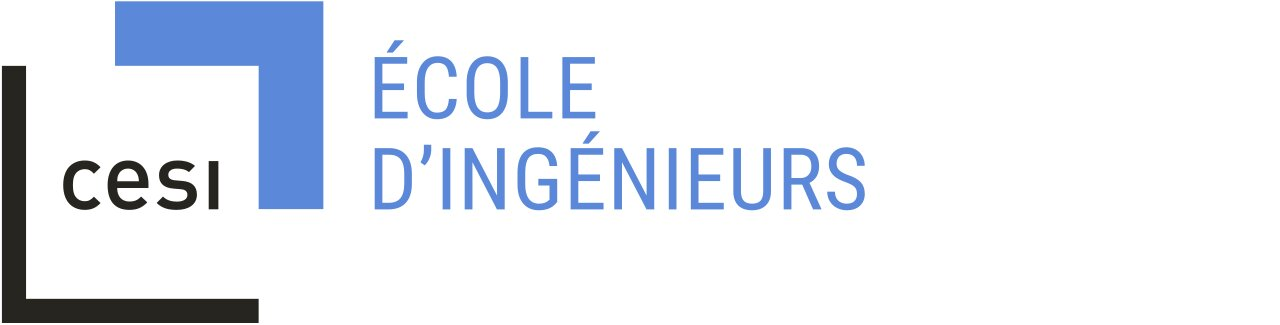
Concepteur : Mellila BOUAM
</div>

# Introduction

L'objectif de ce workshop est de vous initier au [transfer learning](https://fr.wikipedia.org/wiki/Apprentissage_par_transfert), une technique utilisée pour exploiter les connaissances acquises par un modèle entraîné sur un grand dataset sur une tâche applicative où la quantité de données disponibles est limitée.

Nous commencerons par faire une analyse intuitive de l'efficacité du transfer learning. Nous préparerons ensuite la première partie, c'est-à-dire les données qui seront utilisées, du workshop d'[annotations d'images](https://fr.wikipedia.org/wiki/Annotation_automatique_d%27images) (image captioning) dans lequel nous allons effectuer l'entraînement d'un modèle en recourant au transfer learning.



## Qu'est-ce que le transfer learning ?

Le **Transfer Learning** consiste à prendre des features apprises sur un problème, et les utiliser sur un autre problème similaire. Par exemple, les features d'un modèle qui a appris à reconnaître des chats peut être utile pour initialiser un modèle qui va reconnaître des tigres.

Le transfer learning est souvent effectué sur des tâches où le dataset contient trop peu d'exemples pour entraîner un modèle à partir de zéro.

Le workflow typique du transfer learning dans le contexte du deep learning est le suivant :

1. Prendre les couches d'un modèle pré-entraîné.
2. Geler les poids de ces couches.
3. Ajouter des couches entraînables (dont les poids ne sont pas gelés) à la fin du modèle. Elle vont servir à convertir les features en prédictions sur un nouveau dataset.
4. Entraîner les nouvelles couches sur le nouveau dataset.

- Quel est l'intérêt de geler les poids des couches du modèle pré-entraîné (étape 2)? 
<em>À COMPLÉTER</em>


Une dernière étape optionnelle, le **fine-tuning** consiste à dégeler toutes les couches du modèle obtenu après le processus précédent et le réentraîner sur le nouveau dataset avec un learning rate très bas. 

- Quel est l'intérêt de l'étape de fine-tuning ? Pourquoi utilise-on un learning rate très bas ?
<em>À COMPLÉTER</em>




# Partie 1 : Intuition sur le transfer learning

Dans cette partie, nous allons charger le modèle [InceptionV3](https://paperswithcode.com/method/inception-v3) pré-entraîné sur une tâche de classification sur le dataset [ImageNet](https://image-net.org/). Nous allons ensuite utiliser ce modèle pour calculer des représentations vectorielles (appelées [embeddings](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture?hl=fr)) d'images du dataset [cats vs dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs). Nous allons ensuite représenter chaque embedding sur le plan et interpréter les résultats.

## Chargement des données
Nous chargeons premièrement le dataset cats vs. dogs en utilisant [TFDS](https://www.tensorflow.org/datasets?hl=fr) (TensorFlow Datasets).

Le transfer learning marche particulièrement sur les petits datasets. Complétez le code ci-dessous, vous devez afficher le nombre d'exemples de chaque dataset.

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [19]:
# On charge un dataset de tensorflow

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load("cats_vs_dogs",
    #"cifar10",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

# Nb of training samples
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
# Nb of validation samples
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
# Nb of test samples
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dataset cats_vs_dogs downloaded and prepared to C:\Users\Nyu\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


Visualisons les 9 premières images du dataset. On remarquera que la classe 0 correspond à "cat" et la classe 1 correspond à dog.

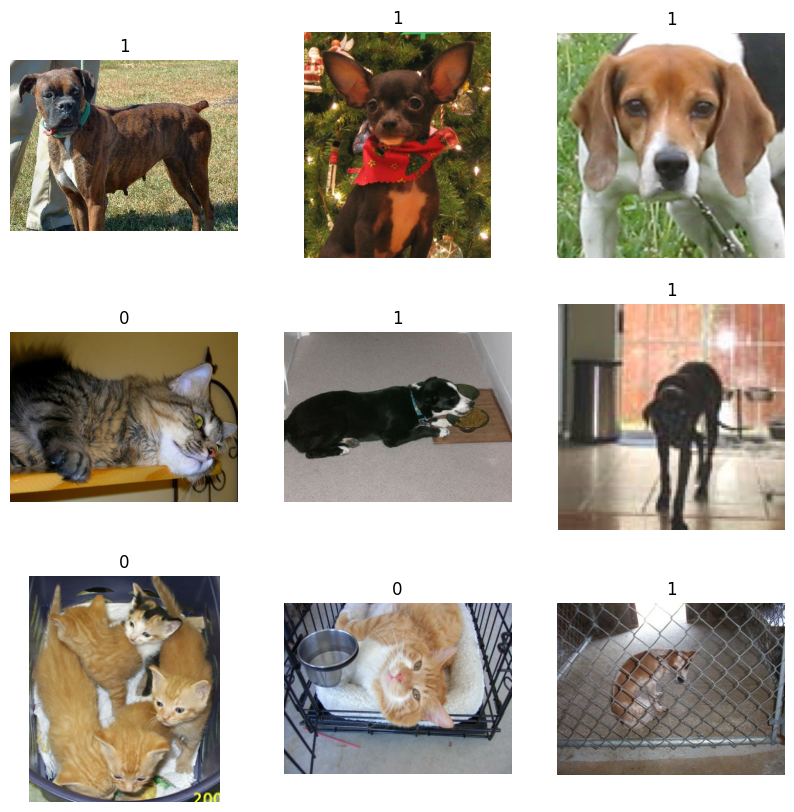

In [20]:
# On affiche quelques exemples

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

## Standardisation des données
Les images du dataset sont de tailles différentes. Nous devons donc les redimensionner pour correspondre à la taille attendue par le modèle que l'on va utiliser : InceptionV3.

Nous redimensionnons les images pour une taille de (299x299). Pour le faire, vous aurez besoin d'une fonction de redimensionnement d'images, que [TensorFLow vous fournira](https://www.tensorflow.org/api_docs/python/tf/image/resize). Par ailleurs, si vous voulez effectuer le redimensionnement en une seule instruction, vous pouvez utiliser les [expressions lambda](https://www.w3schools.com/python/python_lambda.asp)

In [21]:
# On resize les images 

size = (299, 299)

train_ds = train_ds.map(
    lambda x, y: (tf.image.resize(x, size), y)
)
validation_ds = validation_ds.map(
    lambda x, y: (tf.image.resize(x, size), y)
)
test_ds = test_ds.map(
    lambda x, y: (tf.image.resize(x, size), y)
)


In [22]:
 # On preprocess les images pour pouvoir les donner en entrées à InceptionV3

train_ds = train_ds.map(
    lambda x, y: (keras.applications.inception_v3.preprocess_input(x), y)
)
validation_ds = validation_ds.map(
    lambda x, y: (keras.applications.inception_v3.preprocess_input(x), y)
)
test_ds = test_ds.map(
    lambda x, y: (keras.applications.inception_v3.preprocess_input(x), y)
)


In [23]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)


In [24]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet

# Si on met weights=None -> on aura des embeddings qui ne contiennent pas d'info
# Si on met weights='imagenet' -> on aura des embeddings sémantiquement pertinents même si le modèle n'a été entraîné ni sur cats vs dogs ni cifar10
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet', pooling='avg')

À quoi correspond le paramètre **include_top = false** ?
<em>À COMPLÉTER</em>
 
À quoi correspond le paramètre **weights='imagenet'** ? 
<em>À COMPLÉTER</em>

À quoi correspond le paramètre **pooling='avg'** ?
<em>À COMPLÉTER</em>


On définit maintenant le [modèle que l'on va utiliser](https://www.tensorflow.org/api_docs/python/tf/keras/Model) :

In [25]:
# Définition du modèle d'embedding utilisant InceptionV3
inputs = keras.Input(shape=(299, 299, 3))
x = image_model(inputs)
model = keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
Total params: 21802784 (83.17 MB)
Trainable params: 21768352 (83.04 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


On calcule les embeddings des images du dataset de test. Le dataset comprend 2326 images et la taille d'un embedding est de 2048 (regardez la documentation de keras.Model au dessus) :

In [26]:
# Calcul des embeddings des images du dataset de test

output = model.predict(test_ds)

print(output.shape)

73/73 [==============================] - 82s 1s/step
(2326, 2048)


In [27]:
# On construit la liste des vraies classes des exemples du dataset de test (1 -> chien, 0 -> chat)

labels = []
for _, y in test_ds:
    labels.extend(
        y.numpy().tolist()
    )

Afin de montrer la pertinence d'utiliser un modèle InceptionV3 préentraîné sur ImageNet, nous allons visualiser les embeddings du dataset de test et voir s'il y a une certaine séparation entre les classes du dataset.

Afin de visualiser l'embedding d'une image, celui-ci doit être de dimension 2. Or, les embeddings calculés sont de taille 2048. Nous allons donc utiliser l'algorithme [t-SNE](https://fr.wikipedia.org/wiki/Algorithme_t-SNE) afin de réduire la dimension de 2048 à 2.

t-SNE est un algorithme de réduction de dimension utilisé pour visualiser des données à grande dimension. L'algorithme tente de trouver une configuration qui préserve le plus possible la proximité entre les points lors du passage de l'espace de grande dimension (ici 2048) à l'espace de faible dimension (ici 2). Nous utiliserons l'implémentation de la library [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).


In [28]:
# On applique l'algorithme tSNE aux embeddings afin de réduire leur dimension
# et pouvoir les afficher (embeddings de tailles 2048 -> 2)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(output)

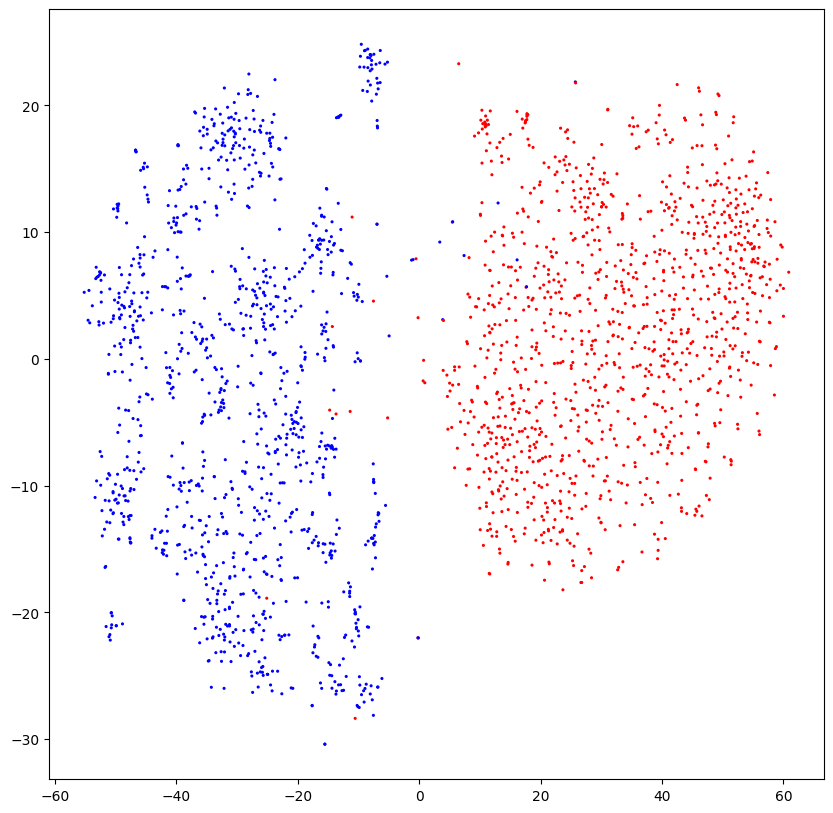

In [29]:
# On définit la couleur associée à chaque classe (seules 2 classes sont utilisées dans le cas cats vs dogs)

colors = {0:'red', 
          1:'blue'}

# On plot les embeddings des images calculés par InceptionV3
# Chaque point correspond à une image et ses coordonnées sont l'embedding tsne de cette image
plt.figure(figsize=(10, 10))
plt.scatter(*tsne.T, s=1.5, c=[colors[l] for l in labels])

# Partie 2 : Préparation des données pour le transfer learning sur une tâche d'image captioning

L'objectif de cette partie est de préparer les données, à travers des prétraitements, pour pouvoir entraîner un modèle sur la tâche d'image captioning. La tâche d'image captioning consiste à prendre une image en entrée et de donner en sortie, une "phrase" décrivant ce que contient cette image. Cette dernière partie sera abordée dans le Workshop suivant.

Nous allons donc ici préparer les données pour ce prochain workshop où on entraînera un modèle composé d'un CNN InceptionV3 préentraîné sur ImageNet pour encoder les images du dataset COCO en embeddings, suivi d'un RNN qui servira à décoder l'embedding et sortir la description textuelle de l'image. Cet entraînement représente un exemple typique de transfer learning.

Une légère modification que l'on peut faire au workflow de transfer learning décrit plus tôt est qu'au lieu de geler les poids du modèle préentraîné (InceptionV3), on peut précalculer les embeddings des images du dataset et les enregistrer dans le disque. Ceci servira à sacrifier un peu d'espace disque contre du temps d'éxecution (inutile de calculer les embeddings des images à chaque epochs) et de la mémoire GPU (inutile de charger le modèle InceptionV3 pendant l'entraînement).

Avec cette modification par contre, il ne sera plus possible d'effectuer la phase de fine-tuning qui consiste à compléter l'entraînement du modèle InceptionV3 avec un ajustement très léger des poids (learning rate très bas) pour optimiser les embeddings qu'il construit. 

# 1 Téléchargement des données :
Tout d'abord, nous devons importer les bibliothèques dont nous aurons besoin pour cette partie.

In [30]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

Vous devez télécharger le dataset [MS COCO](https://cocodataset.org/#home). Ce dataset contient 82000 images annotés chacunes avec 5 légendes. Téléchargez le [dataset](http://images.cocodataset.org/zips/train2014.zip), les [annotations correspondantes](http://images.cocodataset.org/annotations/annotations_trainval2014.zip), et décompressez-les dans le bon répertoire. Le code ci-dessous affiche le chemin d'accès du dossier devant contenir les données ainsi que le fichier des annotations (`annotation_file` et `PATH`).

In [31]:
# Chemin du fichier d'annotations
annotation_folder = os.path.abspath('.')+"/annotations/"
annotation_file = annotation_folder+"captions_train2014.json"

# Chemin du dossier contenant les images à annoter
image_folder = '/train2014/'
PATH = os.path.abspath('.') + image_folder

print("annotation file ", annotation_file)
print("le chemin PATH ", PATH)

annotation file  C:\Users\Nyu\Documents\New folder\Projet Data Science - WS\Projet-Data-Science-WS\Corrigés/annotations/captions_train2014.json
le chemin PATH  C:\Users\Nyu\Documents\New folder\Projet Data Science - WS\Projet-Data-Science-WS\Corrigés/train2014/


In [34]:
with open(annotation_folder+"/captions_val2014.json", 'r') as f:
    annotations = json.load(f)

In [35]:
with open(annotation_folder+"instances_val2014.json", 'r') as f:
    instances = json.load(f)

On veut sélectionner un sous-ensemble d'images afin de rendre l'apprentissage plus rapide. Le but est de prendre seulement 35000 images au lieu des 82000 du dataset d'origine. Pour faire ceci, on pourra créer une structure qui associe chaque à image sa liste des annotations. Comment on pourrait représenter ces données intermédiaires ?
<em>À COMPLÉTER</em>


In [36]:
# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = f"<start> {val['caption']} <end>"
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)


In [37]:
# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:2000]
print(len(train_image_paths))

2000


Maintenant, il est temps de construire notre jeu de données à proprement parler. Le code produisant ce jeu de données est composée de :
<ul>
        <li>La liste `img_name_vector` qui contient les noms des fichers d'images associés à aux annotations. C'est les exemples dans le jeu de données. </li>
        <li>La liste `train_captions` contenant les annotations. C'est les labels.</li>
</ul>
Vous pouvez afficher un exemple pour vérification.

In [38]:
# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list))


10004 10004
<start> A woman celebrating a birthday in a convention hall. <end>


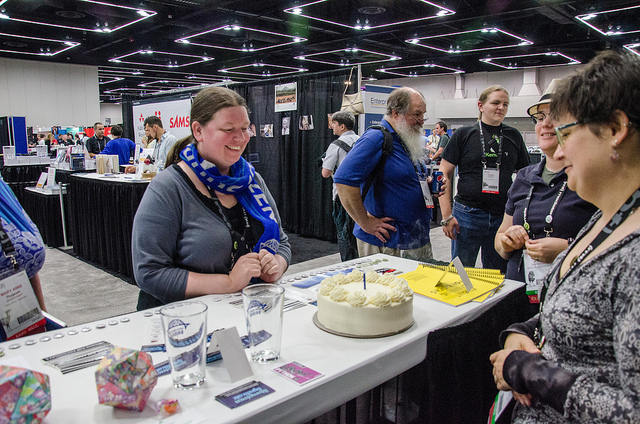

In [39]:
print(len(train_captions), len(img_name_vector))
print(train_captions[0])
Image.open(img_name_vector[0])

# 2 Prétraitement des images
Ce que l'on va faire ensuite, c'est charger le réseau de neurones qui s'occupera de la partie vision du problème d’annotation. En effet, l'architecture globale du système contiendra deux parties :
<ul>
    <li>Un CNN dont le rôle sera de résumer et d'extraire le contenu brute et volumineux de l'information portée par les pixels en une représentation compacte qui regroupe les caractéristiques essentielles pour effectuer l'annotation.</li>
    <li>Et un RNN qui aura en entrée cette représentation compacte et dont le but est d'apprendre le prochain mot à partir des premiers mot de l'annotation.</li>
</ul>

Pour créer un nouveau modèle vous pourrez utiliser la fonction `tf.keras.Model` de [tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/Model). Pour la partie CNN, vous n'aurez pas à concevoir votre propre architecture pour le réseau de neurones, vous devez utiliser une architecture qui existe déjà et qui se nomme [InceptionV3](https://paperswithcode.com/method/inception-v3). Vous pouvez télécharger les poids de cette architecture obtenus par pré-entrainement sur le dataset [ImageNet](http://www.image-net.org/) (utilisé dans la classification). Ce réseau sera donc entrainé à faire de la classification d'images, mais vous allez utiliser la dernière couche cachée de ce réseau (c'est-à-dire l'avant-dernière couche car la dernière correspond aux classes de ImageNet), pour la mettre plus tard en entrée à votre RNN. Le RNN, comme nous l'avons dit précédemment, devra apprendre à faire de l'annotation en se basant sur ces représentations d'images. 

Comme l'entrainement s'effectue généralement en faisant plusieurs passes sur les données, l'intérêt de précalculer des représentations d'images est de ne pas avoir à faire passer à chaque fois les images dans le CNN et d'éviter les couts d'entrainement associés au CNN. L'inconvénient potentiel est que les performances seront probablement plus limitées car l'entrainement ne portera que sur les poids du RNN et pas ceux du CNN.

In [40]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


In [41]:
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    # Lecture du fichier image
    img = tf.io.read_file(image_path)
    # Decodage de l'image en RGB
    img = tf.image.decode_jpeg(img, channels=3)
    # Redimensionnement de l'image en taille (299, 299)
    img = tf.image.resize(img, (299, 299))
    # Normalisation des pîxels de l'image entre -1 et 1
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

Puisqu'on a déjà un CNN préentrainé, il convient mieux d'effectuer l'entrainement sur les représentations retournées par le CNN car elles sont plus compactes et donc moins couteuses en mémoire et en temps. Pour cela, il convient de les mettre en les mettre en cache au niveau du disque si votre RAM n'est pas assez grande. La dernière couche du CNN a la forme `8x8x2048`. Vous allez ensuite stocker ces images sous forme de `numpy.array` au niveau du disque grâce à la fonction `np.save()`.

**Remarque:** Les traitements dans TensorFlow sont effectués par batch (c'est plus simple pour le GPU), donc il faut configurer votre batch pour pouvoir faire passer vos images dans InceptionV3.

In [42]:
from tqdm import tqdm

# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(
            path_of_feature, bf.numpy()
        )

100%|██████████| 125/125 [02:42<00:00,  1.30s/it]


# 3 Prétraitement des annotations

Pour faire de l'annotation nous devons avoir la possibilité de traiter le texte de manière automatique en suivant les étapes ci-dessous :
<ul>
    <li>Construire un vocabulaire des mots contenus dans les légendes. Pour cela nous devons tokeniser (diviser) les mots dans les légendes sur les caractères spéciaux (espaces, ponctuation, signes spéciaux, ...).</li>
    <li>Ce vocabulaire sera beaucoup trop volumineux, on devra se limiter par exemple aux 5000 premiers mots les plus fréquents. Vous pourrez remplacer les autres mots par un token spécial nommé "UNK" (unknown).</li>
    <li>Les mots doivent aussi être numérotés dans le dictionnaire pour en former des annotations représentés de manière lisible pour les algorithme de traitement de texte.</li>
    <li>Les exemples (annotations) seront remplis pour qu'ils aient tous la même taille (la taille maximale des annotations).</li>
</ul>

In [43]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)

# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

Par la suite (dans le prochain workshop), nous reprendrons cette deuxième partie et nous enchaînerons avec la formation du jeu d'entrainement et de test, la construction du modèle que l'on va entraîner ainsi que la phase d'entraînement et de test.

In [44]:
max_length

45